## Parser_util.py

Se crea un argument parser usando la librería argparse para definir los argumentos que pueden pasar al script desde la línea de comandos.

In [2]:
# coding=utf-8
import os
import argparse


def get_parser():
    parser = argparse.ArgumentParser()
    parser.add_argument('-root', '--dataset_root',
                        type=str,
                        help='path to dataset',
                        default='..' + os.sep + 'dataset')

    parser.add_argument('-exp', '--experiment_root',
                        type=str,
                        help='root where to store models, losses and accuracies',
                        default='..' + os.sep + 'output')

    parser.add_argument('-nep', '--epochs',
                        type=int,
                        help='number of epochs to train for',
                        default=5)

    parser.add_argument('-lr', '--learning_rate',
                        type=float,
                        help='learning rate for the model, default=0.001',
                        default=0.001)

    parser.add_argument('-lrS', '--lr_scheduler_step',
                        type=int,
                        help='StepLR learning rate scheduler step, default=20',
                        default=5)

    parser.add_argument('-lrG', '--lr_scheduler_gamma',
                        type=float,
                        help='StepLR learning rate scheduler gamma, default=0.5',
                        default=0.5)

    parser.add_argument('-its', '--iterations',
                        type=int,
                        help='number of episodes per epoch, default=100',
                        default=100)

    parser.add_argument('-cTr', '--classes_per_it_tr',
                        type=int,
                        help='number of random classes per episode for training, default=60',
                        default=10)

    parser.add_argument('-nsTr', '--num_support_tr',
                        type=int,
                        help='number of samples per class to use as support for training, default=5',
                        default=5)

    parser.add_argument('-nqTr', '--num_query_tr',
                        type=int,
                        help='number of samples per class to use as query for training, default=5',
                        default=5)

    parser.add_argument('-cVa', '--classes_per_it_val',
                        type=int,
                        help='number of random classes per episode for validation, default=5',
                        default=10)

    parser.add_argument('-nsVa', '--num_support_val',
                        type=int,
                        help='number of samples per class to use as support for validation, default=5',
                        default=5)

    parser.add_argument('-nqVa', '--num_query_val',
                        type=int,
                        help='number of samples per class to use as query for validation, default=15',
                        default=15)

    parser.add_argument('-seed', '--manual_seed',
                        type=int,
                        help='input for the manual seeds initializations',
                        default=7)

    parser.add_argument('--cuda',
                        action='store_true',
                        help='enables cuda')

    return parser


## Protonet.py

Modelo basado en Prototypical Networks, una arquitectura utilizada para Few-Shot Learning.

In [3]:
import torch.nn as nn
import torch

# Devuelve un bloque de convolución
def conv_block(in_channels, out_channels):
    '''
    returns a block conv-bn-relu-pool
    '''
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, 3, padding=1),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(),
        nn.MaxPool2d(2)
    )



# Convierte imágenes en embeddings
class ProtoNet(nn.Module):
    def __init__(self, x_dim=1, hid_dim=64, z_dim=10):
        super(ProtoNet, self).__init__()
        self.encoder = nn.Sequential(
            conv_block(x_dim, hid_dim),
            conv_block(hid_dim, hid_dim),
            conv_block(hid_dim, hid_dim),
            conv_block(hid_dim, z_dim),
        )
        #self.fc = nn.Linear(z_dim, 10)

    def forward(self, x):
        x = self.encoder(x)
        x = x.view(x.size(0), -1)
        # x = self.fc(x)
        return x

    # Calcula prototipos de cada clase
    def get_prototypes(self, embeddings, labels, n_support):
        unique_labels = torch.unique(labels)
        prototypes = []
        
        for label in unique_labels:
            class_samples = embeddings[labels == label][:n_support]
            class_prototype = class_samples.mean(dim=0)
            prototypes.append(class_prototype)
        
        return torch.stack(prototypes)


## Prototypical_batch_sampler.py

Define un muestreador por lotes (batch sampler) que selecciona datos para entrenar un modelo Few-Shot Learning basado en Prototypical Networks.

Esta clase crea episodios de entrenamiento siguiendo el paradigma de Few-Shot Learning:

- En cada iteración selecciona classes_per_it clases al azar.
- Dentro de cada clase, selecciona num_samples ejemplos.
- Devuelve los índices en un batch mezclado.


In [4]:
# coding=utf-8
import numpy as np
import torch


class PrototypicalBatchSampler(object):
    '''
    PrototypicalBatchSampler: yield a batch of indexes at each iteration.
    Indexes are calculated by keeping in account 'classes_per_it' and 'num_samples',
    In fact at every iteration the batch indexes will refer to  'num_support' + 'num_query' samples
    for 'classes_per_it' random classes.

    __len__ returns the number of episodes per epoch (same as 'self.iterations').
    '''

    def __init__(self, labels, classes_per_it, num_samples, iterations):
        '''
        Initialize the PrototypicalBatchSampler object
        Args:
        - labels: an iterable containing all the labels for the current dataset
        samples indexes will be infered from this iterable.
        - classes_per_it: number of random classes for each iteration
        - num_samples: number of samples for each iteration for each class (support + query)
        - iterations: number of iterations (episodes) per epoch
        '''
        super(PrototypicalBatchSampler, self).__init__()
        self.labels = labels
        self.classes_per_it = classes_per_it
        self.sample_per_class = num_samples
        self.iterations = iterations

        self.classes, self.counts = np.unique(self.labels, return_counts=True)
        self.classes = torch.LongTensor(self.classes)

        # create a matrix, indexes, of dim: classes X max(elements per class)
        # fill it with nans
        # for every class c, fill the relative row with the indices samples belonging to c
        # in numel_per_class we store the number of samples for each class/row
        self.idxs = range(len(self.labels))
        self.indexes = np.empty((len(self.classes), max(self.counts)), dtype=int) * np.nan
        self.indexes = torch.Tensor(self.indexes)
        self.numel_per_class = torch.zeros_like(self.classes)
        for idx, label in enumerate(self.labels):
            label_idx = np.argwhere(self.classes == label).item()
            self.indexes[label_idx, np.where(np.isnan(self.indexes[label_idx]))[0][0]] = idx
            self.numel_per_class[label_idx] += 1

    def __iter__(self):
        '''
        yield a batch of indexes
        '''
        spc = self.sample_per_class
        cpi = self.classes_per_it

        for it in range(self.iterations):
            batch_size = spc * cpi
            batch = torch.LongTensor(batch_size)
            c_idxs = torch.randperm(len(self.classes))[:cpi]
            for i, c in enumerate(self.classes[c_idxs]):
                s = slice(i * spc, (i + 1) * spc)
                # FIXME when torch.argwhere will exists
                label_idx = torch.arange(len(self.classes)).long()[self.classes == c].item()
                sample_idxs = torch.randperm(self.numel_per_class[label_idx])[:spc]
                batch[s] = self.indexes[label_idx][sample_idxs]
            batch = batch[torch.randperm(len(batch))]
            yield batch

    def __len__(self):
        '''
        returns the number of iterations (episodes) per epoch
        '''
        return self.iterations


## Prototypical_loss.py

Función de pérdida prototípica, utilizada en Redes Prototípicas para few-shot learning. Su objetivo es calcular qué tan bien un modelo puede clasificar ejemplos basándose en la distancia entre sus representaciones y los prototipos de clase.

In [5]:
# coding=utf-8
import torch
from torch.nn import functional as F
from torch.nn.modules import Module


class PrototypicalLoss(Module):
    '''
    Loss class deriving from Module for the prototypical loss function defined below
    '''
    def __init__(self, n_support):
        super(PrototypicalLoss, self).__init__()
        self.n_support = n_support

    def forward(self, input, target):
        return prototypical_loss(input, target, self.n_support)


def euclidean_dist(x, y):
    '''
    Compute euclidean distance between two tensors
    '''
    # x: N x D
    # y: M x D
    n = x.size(0)
    m = y.size(0)
    d = x.size(1)
    if d != y.size(1):
        raise Exception

    x = x.unsqueeze(1).expand(n, m, d)
    y = y.unsqueeze(0).expand(n, m, d)

    return torch.pow(x - y, 2).sum(2)


def prototypical_loss(input, target, n_support):
    '''
    Inspired by https://github.com/jakesnell/prototypical-networks/blob/master/protonets/models/few_shot.py

    Compute the barycentres by averaging the features of n_support
    samples for each class in target, computes then the distances from each
    samples' features to each one of the barycentres, computes the
    log_probability for each n_query samples for each one of the current
    classes, of appartaining to a class c, loss and accuracy are then computed
    and returned
    Args:
    - input: the model output for a batch of samples
    - target: ground truth for the above batch of samples
    - n_support: number of samples to keep in account when computing
      barycentres, for each one of the current classes
    '''
    target_cpu = target.to('cpu')
    input_cpu = input.to('cpu')

    def supp_idxs(c):
        # FIXME when torch will support where as np
        return target_cpu.eq(c).nonzero()[:n_support].squeeze(1)

    # FIXME when torch.unique will be available on cuda too
    classes = torch.unique(target_cpu)
    n_classes = len(classes)
    # FIXME when torch will support where as np
    # assuming n_query, n_target constants
    n_query = target_cpu.eq(classes[0].item()).sum().item() - n_support

    support_idxs = list(map(supp_idxs, classes))

    prototypes = torch.stack([input_cpu[idx_list].mean(0) for idx_list in support_idxs])
    # FIXME when torch will support where as np
    query_idxs = torch.stack(list(map(lambda c: target_cpu.eq(c).nonzero()[n_support:], classes))).view(-1)

    query_samples = input.to('cpu')[query_idxs]
    dists = euclidean_dist(query_samples, prototypes)

    log_p_y = F.log_softmax(-dists, dim=1).view(n_classes, n_query, -1)

    target_inds = torch.arange(0, n_classes)
    target_inds = target_inds.view(n_classes, 1, 1)
    target_inds = target_inds.expand(n_classes, n_query, 1).long()

    loss_val = -log_p_y.gather(2, target_inds).squeeze().view(-1).mean()
    _, y_hat = log_p_y.max(2)
    acc_val = y_hat.eq(target_inds.squeeze(2)).float().mean()

    return loss_val,  acc_val


## Dataset MNIST

In [6]:
import torch
import torchvision.transforms as transforms
from torchvision.datasets import MNIST
from torch.utils.data import Dataset


class MNISTFewShotDataset(Dataset):
    def __init__(self, mode='train', root='../dataset', transform=None):
        """
        Dataset adaptado de Omniglot para MNIST en el contexto de few-shot learning.
        Args:
        - mode: 'train' o 'test'
        - root: directorio donde se guardará el dataset
        - transform: transformaciones aplicadas a las imágenes
        """
        super(MNISTFewShotDataset, self).__init__()
        self.root = root
        self.transform = transform if transform else transforms.ToTensor()

        self.dataset = MNIST(root=self.root, train=(mode == 'train'), download=True, transform=self.transform)
        self.x, self.y = self.dataset.data, self.dataset.targets

    def __getitem__(self, idx):
        img, label = self.x[idx], self.y[idx]
        img = img.unsqueeze(0).float() / 255.0  # Normalizar imágenes a rango [0,1]
        return img, label

    def __len__(self):
        return len(self.dataset)


# Ejemplo de uso
if __name__ == "__main__":
    dataset = MNISTFewShotDataset(mode='train')
    img, label = dataset[0]
    print(f"Shape de la imagen: {img.shape}, Clase: {label}")


Shape de la imagen: torch.Size([1, 28, 28]), Clase: 5


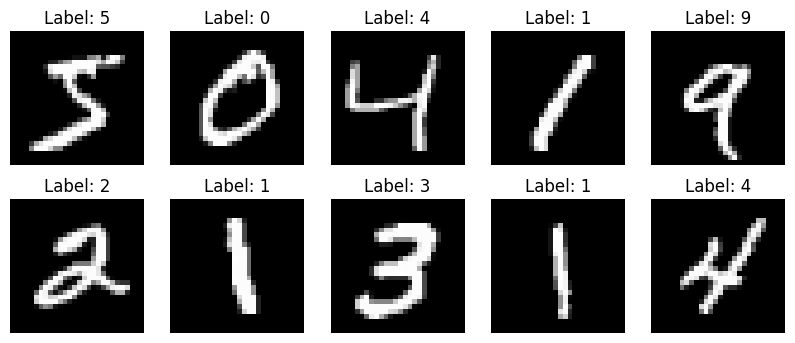

In [7]:
import matplotlib.pyplot as plt

dataset = MNISTFewShotDataset(mode='train')
fig, axes = plt.subplots(2, 5, figsize=(10, 4))

for i, ax in enumerate(axes.flat):
    img, label = dataset[i]
    img = img.squeeze(0).numpy()  # Convertir a numpy array para visualizar
    ax.imshow(img, cmap='gray')
    ax.set_title(f'Label: {label}')
    ax.axis('off')

plt.show()


## Train.py

In [8]:
pip install tqdm

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [9]:
from tqdm import tqdm
import numpy as np
import torch
import os


def init_seed(opt):
    '''
    Disable cudnn to maximize reproducibility
    '''
    torch.cuda.cudnn_enabled = False
    np.random.seed(opt.manual_seed)
    torch.manual_seed(opt.manual_seed)
    torch.cuda.manual_seed(opt.manual_seed)


def init_dataset(opt, mode):
    dataset = MNISTFewShotDataset(mode=mode, root=opt.dataset_root)
    n_classes = len(np.unique(dataset.y))
    if n_classes < opt.classes_per_it_tr or n_classes < opt.classes_per_it_val:
        raise(Exception('There are not enough classes in the dataset in order ' +
                        'to satisfy the chosen classes_per_it. Decrease the ' +
                        'classes_per_it_{tr/val} option and try again.'))
    return dataset

In [10]:
def init_sampler(opt, labels, mode):
    if 'train' in mode:
        classes_per_it = opt.classes_per_it_tr
        num_samples = opt.num_support_tr + opt.num_query_tr
    else:
        classes_per_it = opt.classes_per_it_val
        num_samples = opt.num_support_val + opt.num_query_val

    return PrototypicalBatchSampler(labels=labels,
                                    classes_per_it=classes_per_it,
                                    num_samples=num_samples,
                                    iterations=opt.iterations)


def init_dataloader(opt, mode):
    dataset = init_dataset(opt, mode)
    sampler = init_sampler(opt, dataset.y, mode)
    dataloader = torch.utils.data.DataLoader(dataset, batch_sampler=sampler)
    return dataloader


def init_protonet(opt):
    '''
    Initialize the ProtoNet
    '''
    device = 'cuda:0' if torch.cuda.is_available() and opt.cuda else 'cpu'
    model = ProtoNet().to(device)
    return model


def init_optim(opt, model):
    '''
    Initialize optimizer
    '''
    return torch.optim.Adam(params=model.parameters(),
                            lr=opt.learning_rate)


def init_lr_scheduler(opt, optim):
    '''
    Initialize the learning rate scheduler
    '''
    return torch.optim.lr_scheduler.StepLR(optimizer=optim,
                                           gamma=opt.lr_scheduler_gamma,
                                           step_size=opt.lr_scheduler_step)


def save_list_to_file(path, thelist):
    with open(path, 'w') as f:
        for item in thelist:
            f.write("%s\n" % item)

In [11]:
def train(opt, tr_dataloader, model, optim, lr_scheduler, val_dataloader=None):
    '''
    Train the model with the prototypical learning algorithm
    '''

    device = 'cuda:0' if torch.cuda.is_available() and opt.cuda else 'cpu'

    if val_dataloader is None:
        best_state = None
    train_loss = []
    train_acc = []
    val_loss = []
    val_acc = []
    best_acc = 0

    best_model_path = os.path.join(opt.experiment_root, 'best_model.pth')
    last_model_path = os.path.join(opt.experiment_root, 'last_model.pth')

    for epoch in range(opt.epochs):
        print('=== Epoch: {} ==='.format(epoch))
        tr_iter = iter(tr_dataloader)
        model.train()
        for batch in tqdm(tr_iter):
            optim.zero_grad()
            x, y = batch
            x, y = x.to(device), y.to(device)
            model_output = model(x)
            loss, acc = prototypical_loss(model_output, target=y,
                                n_support=opt.num_support_tr)
            loss.backward()
            optim.step()
            train_loss.append(loss.item())
            train_acc.append(acc.item())
        avg_loss = np.mean(train_loss[-opt.iterations:])
        avg_acc = np.mean(train_acc[-opt.iterations:])
        print('Avg Train Loss: {}, Avg Train Acc: {}'.format(avg_loss, avg_acc))
        lr_scheduler.step()
        if val_dataloader is None:
            continue
        val_iter = iter(val_dataloader)
        model.eval()
        for batch in val_iter:
            x, y = batch
            x, y = x.to(device), y.to(device)
            model_output = model(x)
            loss, acc = prototypical_loss(model_output, target=y,
                                n_support=opt.num_support_val)
            val_loss.append(loss.item())
            val_acc.append(acc.item())
        avg_loss = np.mean(val_loss[-opt.iterations:])
        avg_acc = np.mean(val_acc[-opt.iterations:])
        postfix = ' (Best)' if avg_acc >= best_acc else ' (Best: {})'.format(
            best_acc)
        print('Avg Val Loss: {}, Avg Val Acc: {}{}'.format(
            avg_loss, avg_acc, postfix))
        if avg_acc >= best_acc:
            torch.save(model.state_dict(), best_model_path)
            best_acc = avg_acc
            best_state = model.state_dict()

    torch.save(model.state_dict(), last_model_path)

    for name in ['train_loss', 'train_acc', 'val_loss', 'val_acc']:
        save_list_to_file(os.path.join(opt.experiment_root,
                                       name + '.txt'), locals()[name])

    return best_state, best_acc, train_loss, train_acc, val_loss, val_acc


In [ ]:
def test(opt, test_dataloader, model):
    '''
    Test the model trained with the prototypical learning algorithm
    '''
    device = 'cuda:0' if torch.cuda.is_available() and opt.cuda else 'cpu'
    avg_acc = list()
    predicciones = []
    etiquetas_reales = []
    distancias = []
    for epoch in range(10):
        test_iter = iter(test_dataloader)
        for batch in test_iter:
            x, y = batch
            x, y = x.to(device), y.to(device)
            model_output = model(x)
            _, acc = prototypical_loss(model_output, target=y,
                             n_support=opt.num_support_val)
            avg_acc.append(acc.item())
            classes = torch.unique(y)

            support_idxs = [y.eq(c).nonzero()[:opt.num_support_val].squeeze(1) for c in classes]

            prototypes = torch.stack([model_output[idx_list].mean(0) for idx_list in support_idxs])

            # Para cada instancia de test, encontrar el prototipo más cercano
            distances = torch.cdist(model_output, prototypes)  # Distancia euclidiana
            preds = distances.argmin(dim=1)  # Índice del prototipo más cercano

            # Mostrar resultados
            # print("Predicciones (clase más cercana):", preds.cpu().numpy())
            predicciones.append(preds.cpu().numpy())
            # print("Etiquetas reales:", y.cpu().numpy()) 
            etiquetas_reales.append(y.cpu().numpy())
            # distancias.append(distances)

    avg_acc = np.mean(avg_acc)
    print('Test Acc: {}'.format(avg_acc))

    return avg_acc, predicciones, etiquetas_reales# , distancias

In [13]:
def eval(opt):
    '''
    Initialize everything and train
    '''
    options = get_parser().parse_args()

    if torch.cuda.is_available() and not options.cuda:
        print("WARNING: You have a CUDA device, so you should probably run with --cuda")

    init_seed(options)
    test_dataloader = init_dataset(options)[-1]
    model = init_protonet(options)
    model_path = os.path.join(opt.experiment_root, 'best_model.pth')
    model.load_state_dict(torch.load(model_path))

    test(opt=options,
         test_dataloader=test_dataloader,
         model=model)

## Main

In [15]:
import os
import sys
import torch

options, unknown = get_parser().parse_known_args()
if not os.path.exists(options.experiment_root):
    os.makedirs(options.experiment_root)



if torch.cuda.is_available() and not options.cuda:
    print("WARNING: You have a CUDA device, so you should probably run with --cuda")

init_seed(options)

tr_dataloader = init_dataloader(options, 'train')
val_dataloader = init_dataloader(options, 'val')
# trainval_dataloader = init_dataloader(options, 'trainval')
test_dataloader = init_dataloader(options, 'test')

model = init_protonet(options)
optim = init_optim(options, model)
lr_scheduler = init_lr_scheduler(options, optim)
res = train(opt=options,
            tr_dataloader=tr_dataloader,
            val_dataloader=val_dataloader,
            model=model,
            optim=optim,
            lr_scheduler=lr_scheduler)
best_state, best_acc, train_loss, train_acc, val_loss, val_acc = res
print('Testing with last model..')
test(opt=options,
        test_dataloader=test_dataloader,
        model=model)

model.load_state_dict(best_state)
print('Testing with best model..')
acc, predd, etiq =  test(opt=options,
        test_dataloader=test_dataloader,
        model=model)

/var/folders/px/2nlbn4cs2bbdd7cgvvptqfqc0000gn/T/ipykernel_2068/2916475382.py:45: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  self.indexes[label_idx, np.where(np.isnan(self.indexes[label_idx]))[0][0]] = idx


=== Epoch: 0 ===


100%|██████████| 100/100 [00:05<00:00, 17.78it/s]


Avg Train Loss: 0.37538806080818177, Avg Train Acc: 0.8849999985098839
Avg Val Loss: 0.15357030294835566, Avg Val Acc: 0.9523333275318145 (Best)
=== Epoch: 1 ===


100%|██████████| 100/100 [00:05<00:00, 16.76it/s]


Avg Train Loss: 0.14774383271113037, Avg Train Acc: 0.9577999979257583
Avg Val Loss: 0.11949118748307228, Avg Val Acc: 0.9643333315849304 (Best)
=== Epoch: 2 ===


100%|██████████| 100/100 [00:06<00:00, 16.61it/s]


Avg Train Loss: 0.1148321739025414, Avg Train Acc: 0.9635999995470047
Avg Val Loss: 0.08806222526356577, Avg Val Acc: 0.9716666686534882 (Best)
=== Epoch: 3 ===


100%|██████████| 100/100 [00:05<00:00, 16.89it/s]


Avg Train Loss: 0.09008717717137188, Avg Train Acc: 0.9746000027656555
Avg Val Loss: 0.0732528337277472, Avg Val Acc: 0.9774000066518783 (Best)
=== Epoch: 4 ===


100%|██████████| 100/100 [00:05<00:00, 16.82it/s]


Avg Train Loss: 0.07801196894375607, Avg Train Acc: 0.975400002002716
Avg Val Loss: 0.07448539647273719, Avg Val Acc: 0.9783333414793014 (Best)
Testing with last model..
Test Acc: 0.9795866742134094
Testing with best model..
Test Acc: 0.978633340716362


## Extras

### Verificar instancias de test

In [ ]:
predd[1][:10]

array([7, 5, 8, 2, 5, 5, 6, 8, 6, 3])

In [ ]:
etiq[1][:10]

array([7, 5, 8, 2, 5, 5, 6, 8, 6, 3])

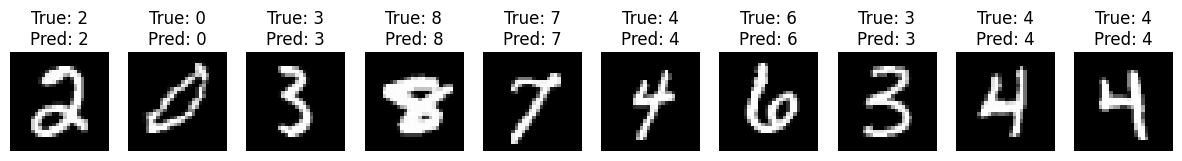

In [35]:
model.eval()
opt, unknown = get_parser().parse_known_args()

images_list = []
true_labels = []
predicted_labels = []

predicciones = []
etiquetas_reales = []

test_iter = test_dataloader
for batch in test_iter:
    x, y = batch
    model_output = model(x)
    _, acc = prototypical_loss(model_output, target=y,
                        n_support=opt.num_support_val)

    classes = torch.unique(y)
    support_idxs = [y.eq(c).nonzero()[:opt.num_support_val].squeeze(1) for c in classes]
    prototypes = torch.stack([model_output[idx_list].mean(0) for idx_list in support_idxs])
    distances = torch.cdist(model_output, prototypes)  # Distancia euclidiana
    preds = distances.argmin(dim=1)  # Índice del prototipo más cercano
    predicciones.append(preds.numpy())
    etiquetas_reales.append(y.numpy())

    images = x.to(next(model.parameters()).device)  

    images_list.append(images)

# Concatenar y truncar al tamaño deseado
images_list = images_list[1][:10]
true_labels = etiquetas_reales[1][:10]
predicted_labels = predicciones[1][:10]


# Graficar imágenes con etiquetas reales y predichas
fig, axes = plt.subplots(1, 10, figsize=(15, 3))
for i, ax in enumerate(axes):
    img = images_list[i]
    if img.dim() == 3 and img.shape[0] == 1:  # (1, 28, 28) -> (28, 28)
        img = img.squeeze(0)
    ax.imshow(img.numpy(), cmap='gray')
    ax.set_title(f'True: {true_labels[i].item()}\nPred: {predicted_labels[i].item()}')
    ax.axis('off')

plt.show()

### Visualizar gráfica con PCA

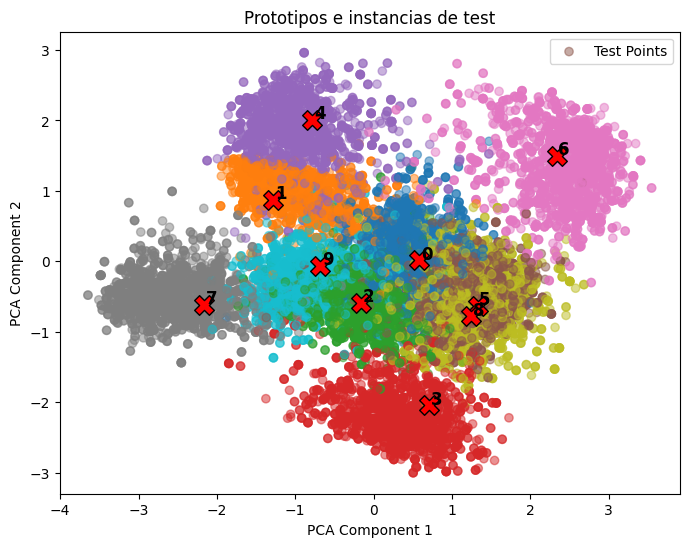

In [34]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Modelo en modo evaluación
model.eval()

# Obtener embeddings de test y etiquetas
test_embeddings = []
test_labels = []

for batch in test_dataloader:
    x, y = batch
    with torch.no_grad():
        embeddings = model(x).view(x.size(0), -1)  # Aplanar
    test_embeddings.append(embeddings.cpu().numpy())
    test_labels.append(y.cpu().numpy())

test_embeddings = np.concatenate(test_embeddings, axis=0)
test_labels = np.concatenate(test_labels, axis=0)

# Obtener prototipos
with torch.no_grad():
    classes = torch.unique(torch.tensor(test_labels))
    support_idxs = [torch.tensor(test_labels).eq(c).nonzero()[:opt.num_support_val].squeeze(1) for c in classes]
    prototypes = torch.stack([torch.tensor(test_embeddings[idx_list]).mean(0) for idx_list in support_idxs])

# Reducir dimensionalidad con PCA a 2D
pca = PCA(n_components=2)
reduced_embeddings = pca.fit_transform(test_embeddings)  # Reducir puntos de test
reduced_prototypes = pca.transform(prototypes.numpy())  # Reducir prototipos

# Graficar
plt.figure(figsize=(8, 6))

# Dibujar puntos de test
scatter = plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], c=test_labels, cmap="tab10", alpha=0.5, label="Test Points")

# Dibujar prototipos con etiquetas
for i, (x, y) in enumerate(reduced_prototypes):
    plt.scatter(x, y, c="red", edgecolors="black", s=200, marker="X")  # Prototipos en rojo
    plt.text(x + 0.02, y + 0.02, str(i), fontsize=12, color="black", fontweight="bold")  # Etiqueta con la clase (0-9)

plt.legend()
plt.title("Prototipos e instancias de test")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.show()


### Visualizar prototipos

In [74]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

class PrototypeDecoder(nn.Module):
    def __init__(self, latent_dim=10):
        super().__init__()
        self.fc = nn.Linear(latent_dim, 128)  # Expandimos a más dimensiones
        self.conv1 = nn.ConvTranspose2d(8, 16, kernel_size=3, stride=2, padding=1, output_padding=1)  
        self.conv2 = nn.ConvTranspose2d(16, 1, kernel_size=4, stride=2, padding=1)  
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.fc(x)  # Expandir dimensiones
        x = x.view(-1, 8, 4, 4)  # Darle forma de imagen pequeña
        x = self.relu(self.conv1(x))  
        x = torch.sigmoid(self.conv2(x))  # Imagen final en escala de grises
        return x  

# Crear modelo y probar
decoder = PrototypeDecoder()
prototypes = torch.randn(10, 10)  # Simular prototipos
recon_images = decoder(prototypes)
print(recon_images.shape)  

torch.Size([10, 1, 16, 16])


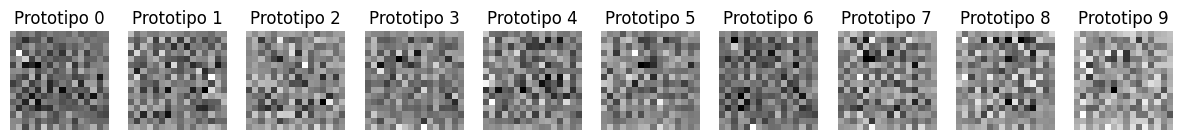

In [75]:
fig, axes = plt.subplots(1, 10, figsize=(15, 3))
for i, ax in enumerate(axes):
    img = recon_images[i].squeeze(0).detach().cpu().numpy()
    ax.imshow(img, cmap="gray")
    ax.set_title(f"Prototipo {i}")
    ax.axis("off")

plt.show()

### Visualizar gráfica con TSNE

/var/folders/px/2nlbn4cs2bbdd7cgvvptqfqc0000gn/T/ipykernel_2068/1757218091.py:42: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap("tab10", 10)  # 10 colores distintos para cada prototipo


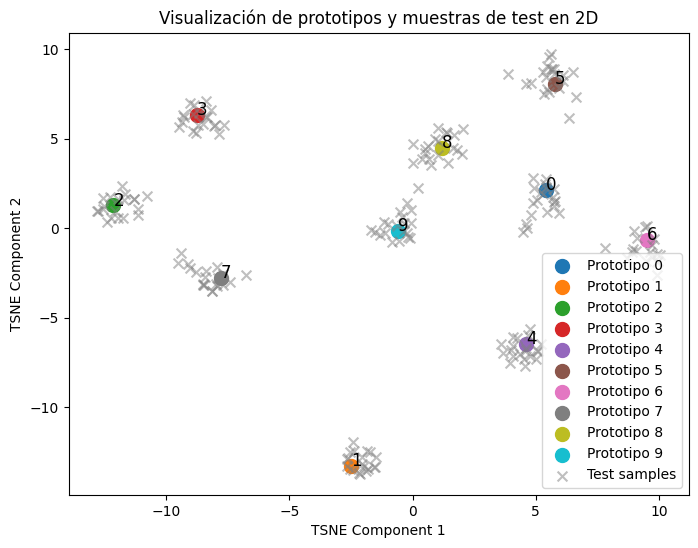

In [77]:
import torch
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
import numpy as np

model.eval()

# Obtener prototipos
opt, unknown = get_parser().parse_known_args()
prototypes = []

for batch in test_dataloader:
    x, y = batch
    with torch.no_grad():
        model_output = model(x)

    classes = torch.unique(y)
    support_idxs = [y.eq(c).nonzero()[:opt.num_support_val].squeeze(1) for c in classes]
    prototypes = torch.stack([model_output[idx_list].mean(0) for idx_list in support_idxs])
    break  # Solo necesitamos un batch para calcular los prototipos

# Obtener embeddings de algunas imágenes de test
test_samples, test_labels = next(iter(test_dataloader))
with torch.no_grad():
    test_embeddings = model(test_samples)

# Normalizar datos antes de t-SNE
scaler = StandardScaler()
data_scaled = scaler.fit_transform(torch.cat([prototypes, test_embeddings]).cpu().numpy())

# Reducción de dimensionalidad a 2D con t-SNE
tsne = TSNE(n_components=2, random_state=42)
data_2d = tsne.fit_transform(data_scaled)

# Separar prototipos y test
proto_2d = data_2d[:10]  # 10 prototipos (uno por cada clase)
test_2d = data_2d[10:]   # Embeddings de test

# Graficar
plt.figure(figsize=(8, 6))
colors = plt.cm.get_cmap("tab10", 10)  # 10 colores distintos para cada prototipo

# Graficar prototipos con colores distintos
for i in range(10):
    plt.scatter(proto_2d[i, 0], proto_2d[i, 1], c=[colors(i)], marker="o", s=100, label=f"Prototipo {i}")
    plt.annotate(str(i), (proto_2d[i, 0], proto_2d[i, 1]), fontsize=12, color="black")

# Graficar test embeddings en gris
plt.scatter(test_2d[:, 0], test_2d[:, 1], c="gray", marker="x", s=50, alpha=0.5, label="Test samples")

plt.legend()
plt.title("Visualización de prototipos y muestras de test en 2D")
plt.xlabel("TSNE Component 1")
plt.ylabel("TSNE Component 2")
plt.show()


### otras pruebas

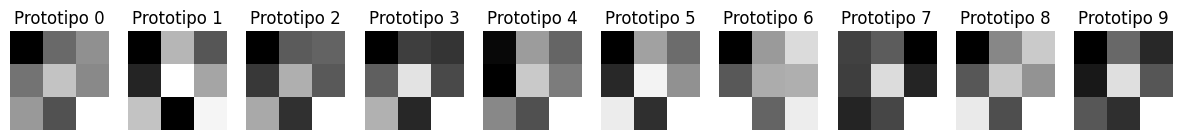

In [43]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

# Obtener la primera capa convolucional del modelo
first_conv_layer = None
for module in model.modules():
    if isinstance(module, torch.nn.Conv2d):
        first_conv_layer = module
        break

if first_conv_layer is not None:
    filters = first_conv_layer.weight  # Pesos de la capa convolucional (filtros)
    input_channels = first_conv_layer.in_channels  # Normalmente 1 (escala de grises)
    num_filters = filters.shape[0]  # Número de filtros (64 en este caso)

    # Obtener prototipos
    with torch.no_grad():
        for batch in test_dataloader:
            x, y = batch
            model_output = model(x)

            classes = torch.unique(y)
            support_idxs = [y.eq(c).nonzero()[:opt.num_support_val].squeeze(1) for c in classes]
            prototypes = torch.stack([model_output[idx_list].mean(0) for idx_list in support_idxs])
            break  # Solo necesitamos un batch

    # Ajustar los prototipos para que tengan 64 canales usando una convolución 1x1
    prototypes = prototypes.unsqueeze(-1).unsqueeze(-1)  # Añadir dimensiones espaciales
    conv1x1 = torch.nn.Conv2d(prototypes.shape[1], num_filters, kernel_size=1)  # Convolución 1x1
    prototypes = conv1x1(prototypes)  # Ahora tienen 64 canales

    # Aplicar convolución transpuesta para reconstrucción
    recon_images = F.conv_transpose2d(prototypes, filters, stride=1)

    # Visualizar imágenes reconstruidas
    fig, axes = plt.subplots(1, 10, figsize=(15, 3))
    for i, ax in enumerate(axes):
        img = recon_images[i].squeeze(0).cpu().detach().numpy()
        ax.imshow(img, cmap="gray")
        ax.set_title(f"Prototipo {i}")
        ax.axis("off")
    plt.show()


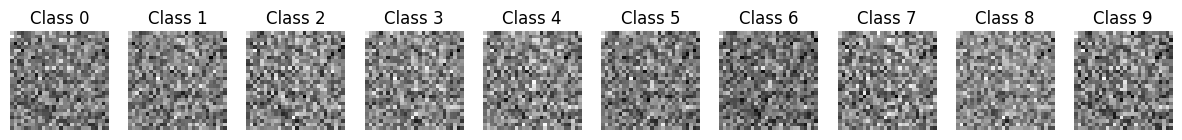

In [ ]:
import torch
import matplotlib.pyplot as plt

def visualize_prototypes(model, test_dataloader, n_classes=10, img_size=(28, 28), n_support=5):
    model.eval()
    embeddings = []
    labels = []

    with torch.no_grad():
        for images, targets in test_dataloader:
            images = images.to(next(model.parameters()).device) 
            emb = model(images)  
            embeddings.append(emb.cpu())  
            labels.append(targets.cpu())

    embeddings = torch.cat(embeddings, dim=0)  
    labels = torch.cat(labels, dim=0) 

    prototypes = model.get_prototypes(embeddings, labels, n_support)

    if hasattr(model, "decoder"):
        print("Usando decoder para reconstruir imágenes a partir de prototipos.")
        prototypes = model.decoder(prototypes).cpu().detach()
    else:
        if prototypes.shape[1] < img_size[0] * img_size[1]:  
            linear_map = torch.nn.Linear(prototypes.shape[1], img_size[0] * img_size[1])
            prototypes = linear_map(prototypes)
        
        lado = int(prototypes.shape[1] ** 0.5)
        if lado * lado == prototypes.shape[1]:  
            prototypes = prototypes.view(n_classes, 1, lado, lado)
        else:
            raise ValueError(f"Los prototipos no tienen una forma adecuada para imágenes: {prototypes.shape}")

    try:
        if prototypes.dim() == 2:  
            lado = int(prototypes.shape[1] ** 0.5)
            if lado * lado == prototypes.shape[1]:
                prototypes = prototypes.view(n_classes, 1, lado, lado)
            else:
                raise ValueError("Los prototipos no tienen una forma adecuada para imágenes.")
        elif prototypes.dim() == 4:  
            if prototypes.shape[1] == 1 or prototypes.shape[1] == 3:  
                pass  
            else:
                prototypes = prototypes[:, 0, :, :]  
    except (RuntimeError, ValueError) as e:
        print(f"Error en reshape: {e}")
        return

    fig, axes = plt.subplots(1, n_classes, figsize=(15, 3))
    for i, ax in enumerate(axes):
        ax.imshow(prototypes[i].detach().numpy().squeeze(), cmap='gray')
        ax.set_title(f'Class {i}')
        ax.axis('off')
    plt.show()

visualize_prototypes(model, test_dataloader, n_classes=10, img_size=(28, 28), n_support=5)


In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

def visualize_prototypes2(prototypes, labels, method='pca'):
    """
    Visualiza los prototipos en 2D usando PCA o t-SNE.
    
    prototypes: Tensor de tamaño (n_clases, dim_embedding)
    labels: Lista de etiquetas (clases) asociadas a cada prototipo
    method: 'pca' o 'tsne' para reducir la dimensionalidad
    """
    prototypes_np = prototypes.cpu().numpy()  # Convertir a NumPy

    # Reducir dimensionalidad a 2D
    if method == 'pca':
        reducer = PCA(n_components=2)
    elif method == 'tsne':
        reducer = TSNE(n_components=2, perplexity=5, random_state=42)
    
    reduced = reducer.fit_transform(prototypes_np)

    # Graficar prototipos en 2D
    plt.figure(figsize=(8, 6))
    for i, (x, y) in enumerate(reduced):
        plt.scatter(x, y, label=f'Class {labels[i]}', alpha=0.8)
        plt.text(x, y, str(labels[i]), fontsize=12, ha='right', va='bottom', weight='bold')

    plt.xlabel("Dim 1")
    plt.ylabel("Dim 2")
    plt.title(f"Prototipos en el espacio 2D usando {method.upper()}")
    plt.legend()
    plt.grid(True)
    plt.show()


In [ ]:
model = init_protonet(options)
avg_acc = list()
opt, unknown = get_parser().parse_known_args()
for epoch in range(10):
    test_iter = iter(test_dataloader)
    for batch in test_iter:
        x, y = batch
        model_output = model(x)

        classes = torch.unique(y)

        # Obtener índices de las muestras de soporte
        support_idxs = [y.eq(c).nonzero()[:opt.num_support_val].squeeze(1) for c in classes]

        # Calcular los prototipos (promedio de los embeddings de soporte)
        prototypes = torch.stack([model_output[idx_list].mean(0) for idx_list in support_idxs])
        print(prototypes)

tensor([[1.5963, 0.9845, 1.1911, 0.0611, 1.0395, 1.3555, 0.8919, 0.8909, 1.0097,
         0.1998],
        [0.3255, 1.5925, 0.3415, 0.4183, 0.9452, 1.7669, 0.6391, 0.6097, 1.3203,
         0.3827],
        [1.9858, 1.5042, 1.1522, 0.3673, 0.9295, 1.2148, 1.2839, 1.5839, 0.8725,
         0.6147],
        [1.7467, 1.1984, 0.8999, 0.3439, 0.7118, 1.4745, 2.2882, 1.7214, 0.8811,
         0.2694],
        [1.7348, 1.1359, 1.2619, 0.4337, 0.9619, 1.5225, 1.2635, 1.8498, 0.8564,
         0.7761],
        [1.2835, 1.1072, 0.7633, 0.1788, 0.6418, 1.2528, 1.2395, 1.3788, 1.2147,
         0.3543],
        [0.9925, 1.1082, 0.5904, 0.0959, 1.1152, 1.2275, 0.9286, 1.2160, 0.9907,
         0.3185],
        [0.7315, 1.3744, 0.3254, 0.2962, 0.6495, 0.8486, 1.7757, 1.5452, 1.0698,
         0.2533],
        [1.5799, 1.3277, 1.1467, 0.2907, 0.9832, 1.6079, 1.1135, 1.5979, 1.0088,
         0.2681],
        [1.7918, 1.1355, 0.7704, 0.4386, 1.1882, 1.2508, 1.4496, 0.9144, 1.0215,
         0.3492]], grad_fn=<

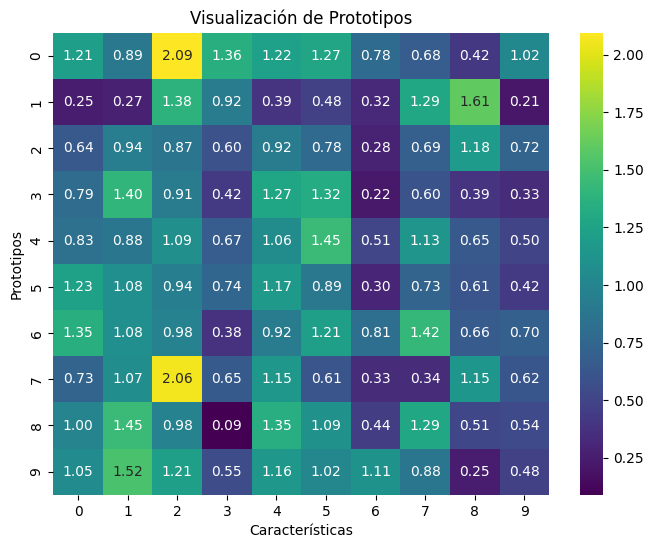

In [ ]:
import torch
import matplotlib.pyplot as plt
import seaborn as sns

# Convertir a numpy
prototypes_np = prototypes.detach().numpy()

# Crear heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(prototypes_np, cmap="viridis", annot=True, fmt=".2f")

plt.title("Visualización de Prototipos")
plt.xlabel("Características")
plt.ylabel("Prototipos")
plt.show()


torch.Size([10, 1, 16, 16])


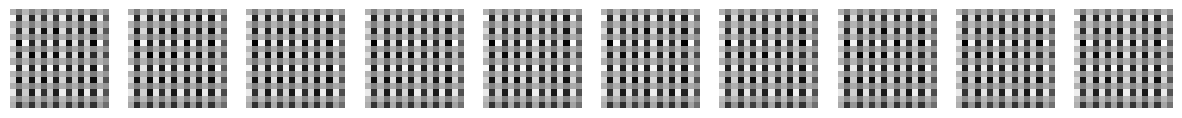

In [ ]:
import torch.nn as nn
import torch
import matplotlib.pyplot as plt

# Definimos el decodificador
class Decoder(nn.Module):
    def __init__(self, z_dim=10):
        super(Decoder, self).__init__()
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(z_dim, 64, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid()  # Normaliza entre [0,1]
        )

    def forward(self, z):
        z = z.view(z.shape[0], z.shape[1], 1, 1)  # Convertir a (batch, z_dim, 1, 1)
        z = self.decoder(z)  # Expandir a (batch, 1, 28, 28)
        return z

# Crear decodificador
decoder = Decoder(z_dim=10)

# Pasar por el decodificador
reconstructed_images = decoder(prototypes)  # Salida esperada: (10, 1, 28, 28)

# Verificamos el tamaño correcto
print(reconstructed_images.shape)  # Debe ser (10, 1, 28, 28)

# Mostrar imágenes reconstruidas
fig, axes = plt.subplots(1, 10, figsize=(15, 2))
for i, ax in enumerate(axes):
    ax.imshow(reconstructed_images[i].detach().squeeze(0), cmap="gray")
    ax.axis("off")
plt.show()


## Ataques

### Ataque #1: FGSM
El FGSM (Fast Gradient Sign Method) funciona generando pequeñas perturbaciones en la entrada para engañar al modelo. Se basa en calcular el gradiente de la pérdida con respecto a la entrada y añadir una perturbación controlada.

In [85]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

def fgsm_attack(model, images, labels, epsilon):
    images.requires_grad_()  # Habilitar gradientes

    # Obtener la salida del modelo antes del ataque
    outputs = model(images)
    if isinstance(outputs, tuple):
        outputs = outputs[0]
    
    # Calcular la pérdida
    loss = F.cross_entropy(outputs, labels)
    model.zero_grad()
    loss.backward()

    # Generar la perturbación adversarial
    perturbation = epsilon * images.grad.sign()
    adv_images = torch.clamp(images + perturbation, 0, 1)
    
    return adv_images

In [86]:
model.eval()
opt, unknown = get_parser().parse_known_args()

images_list = []
true_labels = []
predicted_labels = []

adv_images_list = []  # Para almacenar imágenes adversarias

test_iter = iter(test_dataloader)
for batch in test_iter:
    x, y = batch
    x = x.to(next(model.parameters()).device)
    y = y.to(next(model.parameters()).device)

    model_output = model(x)
    
    # Obtener prototipos
    classes = torch.unique(y)
    support_idxs = [y.eq(c).nonzero()[:opt.num_support_val].squeeze(1) for c in classes]
    prototypes = torch.stack([model_output[idx_list].mean(0) for idx_list in support_idxs])
    
    # Predicciones basadas en la distancia a los prototipos
    distances = torch.cdist(model_output, prototypes)
    preds = distances.argmin(dim=1)

    images_list.append(x)
    true_labels.append(y)
    predicted_labels.append(preds)

    # Aplicar ataque FGSM
    epsilon = 0.1
    adv_x = fgsm_attack(model, x, y, epsilon)
    adv_images_list.append(adv_x)

    break  # Solo queremos un batch para visualizar


/var/folders/px/2nlbn4cs2bbdd7cgvvptqfqc0000gn/T/ipykernel_2068/796374038.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  true_labels = torch.tensor(true_labels)
/var/folders/px/2nlbn4cs2bbdd7cgvvptqfqc0000gn/T/ipykernel_2068/796374038.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  predicted_labels = torch.tensor(predicted_labels)


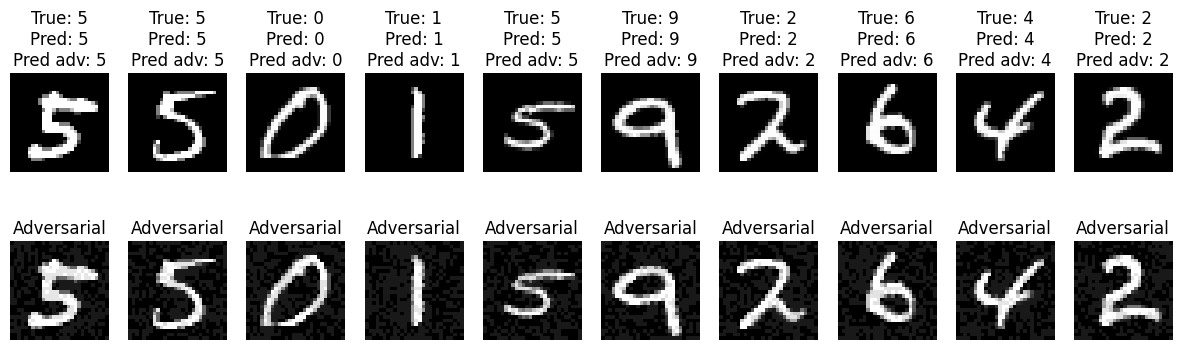

In [104]:
# Seleccionar 10 imágenes originales y adversarias
num_imgs = 10
original_images = images_list[0][:num_imgs].cpu()
adversarial_images = adv_images_list[0][:num_imgs].cpu()
# Convertir a tensores si son listas
true_labels = torch.tensor(true_labels)
predicted_labels = torch.tensor(predicted_labels)

# Asegurar que tienen al menos 1 dimensión antes de indexar
if true_labels.dim() == 0:
    true_labels = true_labels.unsqueeze(0)
if predicted_labels.dim() == 0:
    predicted_labels = predicted_labels.unsqueeze(0)

# Ahora ya se puede hacer slicing sin error
true_labels = true_labels[:num_imgs].cpu()
predicted_labels = predicted_labels[:num_imgs].cpu()


# prediccion adversarial
model_output_adv = model(adversarial_images)
classes = torch.unique(y)
support_idxs = [y.eq(c).nonzero()[:opt.num_support_val].squeeze(1) for c in classes]
# prototypes = torch.stack([model_output[idx_list].mean(0) for idx_list in support_idxs])
distances_adv = torch.cdist(model_output_adv, prototypes)  # Distancia euclidiana
preds_adv = distances_adv.argmin(dim=1)  # Índice del prototipo más cercano
preds_adv = preds_adv[:num_imgs].cpu()


fig, axes = plt.subplots(2, num_imgs, figsize=(15, 4))

for i in range(num_imgs):
    # Original
    img = original_images[i].detach().cpu().squeeze(0).numpy()  # Detach antes de convertir a numpy
    axes[0, i].imshow(img, cmap="gray")
    axes[0, i].set_title(f'True: {true_labels[i].item()}\nPred: {predicted_labels[i].item()}\nPred adv: {preds_adv[i].item()}')
    axes[0, i].axis("off")

    # Adversarial
    img = adversarial_images[i].detach().cpu().squeeze(0).numpy()
    axes[1, i].imshow(img, cmap="gray")
    axes[1, i].set_title("Adversarial")
    axes[1, i].axis("off")

#plt.suptitle("Imágenes Originales vs Adversarias")
plt.show()